In [1]:
# EMG Gesture Recognition System
# For ESP32-S3 with Gravity Analog EMG Sensor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis
import os
import glob
import pickle
import warnings
warnings.filterwarnings('ignore')
# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Add TensorFlow/Keras imports for CNN-LSTM
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, load_model
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    from tensorflow.keras.utils import to_categorical
    TF_AVAILABLE = True
except ImportError:
    print("TensorFlow not available. CNN-LSTM model will be skipped.")
    TF_AVAILABLE = False


In [2]:
# ## 1. Data Loading and Exploration
def load_emg_data(data_folder='data/'):
    """Load all EMG data files from the specified folder"""
    all_data = []
    
    # Get all txt files
    file_pattern = os.path.join(data_folder, '*.txt')
    files = glob.glob(file_pattern)
    
    for file_path in files:
        filename = os.path.basename(file_path)
        print(f"Loading {filename}...")
        
        # Read the file
        with open(file_path, 'r') as f:
            lines = f.readlines()
        
        # Parse each line
        for line in lines:
            if line.strip():
                parts = line.strip().split(',')
                if len(parts) >= 3:
                    all_data.append({
                        'timestamp': float(parts[0]),
                        'value': float(parts[1]),
                        'label': int(parts[2]),
                        'filename': filename
                    })
    
    df = pd.DataFrame(all_data)
    return df

# Load data
df = load_emg_data('data/')
print(f"\nTotal samples loaded: {len(df)}")
print(f"Pinch samples (label=2): {len(df[df['label']==2])}")
print(f"Rotate samples (label=1): {len(df[df['label']==1])}")
print(f"\nData statistics:")
print(df.describe())


Loading pinch1.txt...
Loading pinch2.txt...
Loading pinch3.txt...
Loading pinch4.txt...
Loading pinch5.txt...
Loading pinch6.txt...
Loading rotate1.txt...
Loading rotate2.txt...
Loading rotate3.txt...
Loading rotate4.txt...
Loading rotate5.txt...
Loading rotate6.txt...
Loading rotate7.txt...

Total samples loaded: 195000
Pinch samples (label=2): 90000
Rotate samples (label=1): 105000

Data statistics:
          timestamp          value          label
count  1.950000e+05  195000.000000  195000.000000
mean   1.754630e+12    1760.996092       1.461538
std    3.306157e+06      46.348731       0.498520
min    1.754626e+12      16.000000       1.000000
25%    1.754627e+12    1741.000000       1.000000
50%    1.754631e+12    1763.000000       1.000000
75%    1.754633e+12    1782.000000       2.000000
max    1.754634e+12    3794.000000       2.000000


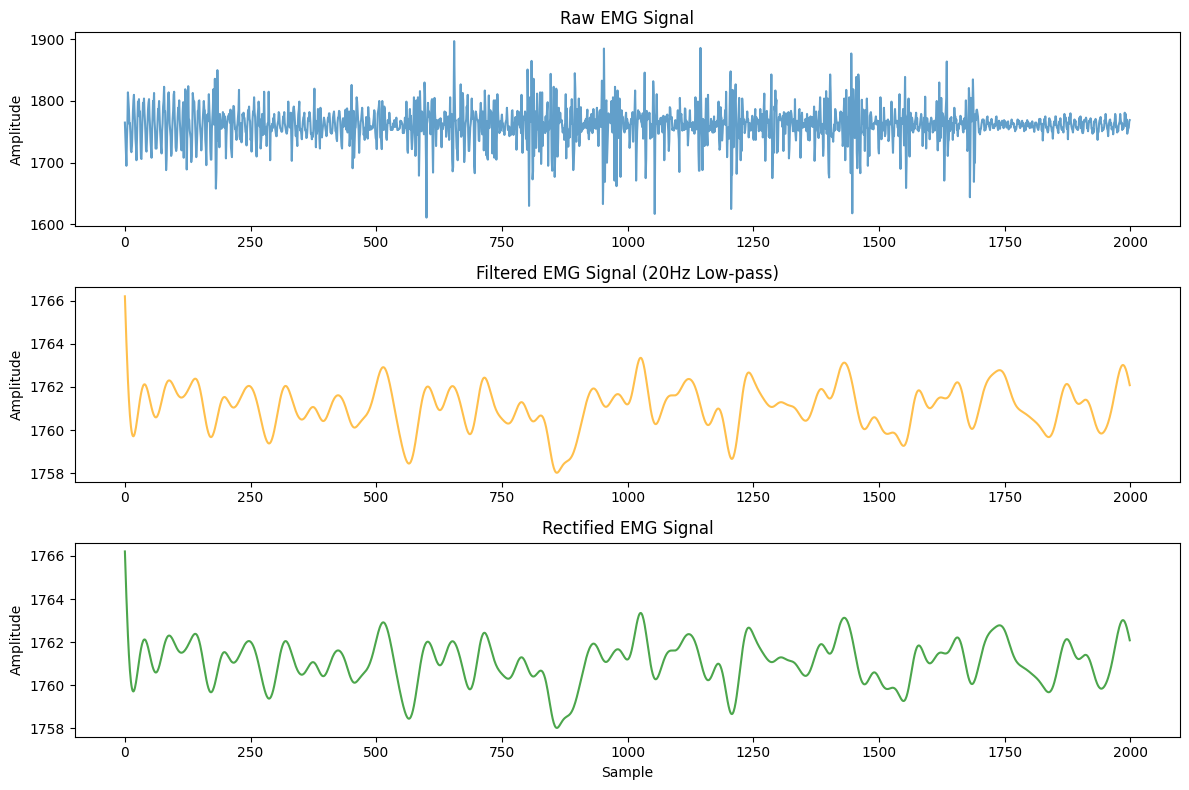

In [6]:
# ## 2. Signal Preprocessing and Filtering
class EMGPreprocessor:
    def __init__(self, sampling_freq=500):
        self.fs = sampling_freq
        
    def butter_bandpass(self, lowcut, highcut, order=4):
        """Create Butterworth bandpass filter"""
        nyq = 0.5 * self.fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype='band')
        return b, a
    
    def butter_lowpass(self, cutoff, order=4):
        """Create Butterworth lowpass filter"""
        nyq = 0.5 * self.fs
        normal_cutoff = cutoff / nyq
        b, a = signal.butter(order, normal_cutoff, btype='low')
        return b, a
    
    def apply_filter(self, data, filter_type='bandpass', lowcut=20, highcut=450):
        """Apply filter to EMG signal"""
        if filter_type == 'bandpass':
            b, a = self.butter_bandpass(lowcut, highcut)
        else:  # lowpass
            b, a = self.butter_lowpass(lowcut)
        
        filtered = signal.filtfilt(b, a, data)
        return filtered
    
    def remove_dc_offset(self, data):
        """Remove DC offset from signal"""
        return data - np.mean(data)
    
    def rectify(self, data):
        """Full-wave rectification"""
        return np.abs(data)
    
    def moving_average(self, data, window_size=50):
        """Apply moving average smoothing"""
        return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Initialize preprocessor
preprocessor = EMGPreprocessor(sampling_freq=1000)

# Apply preprocessing to the entire dataset
df['filtered_value'] = preprocessor.apply_filter(df['value'].values, 'lowpass', 20)
df['rectified'] = preprocessor.rectify(df['filtered_value'].values)

# Visualize preprocessing effects
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
sample_size = 2000
axes[0].plot(df['value'][:sample_size], alpha=0.7)
axes[0].set_title('Raw EMG Signal')
axes[0].set_ylabel('Amplitude')
axes[1].plot(df['filtered_value'][:sample_size], alpha=0.7, color='orange')
axes[1].set_title('Filtered EMG Signal (20Hz Low-pass)')
axes[1].set_ylabel('Amplitude')
axes[2].plot(df['rectified'][:sample_size], alpha=0.7, color='green')
axes[2].set_title('Rectified EMG Signal')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Sample')
plt.tight_layout()
plt.show()

In [7]:
# ## 3. Feature Extraction
class FeatureExtractor:
    def __init__(self, window_size=50, step_size=10):
        self.window_size = window_size
        self.step_size = step_size
    
    def extract_time_domain_features(self, window):
        """Extract time-domain features from EMG window"""
        features = {}
        
        # Statistical features
        features['mean'] = np.mean(window)
        features['std'] = np.std(window)
        features['var'] = np.var(window)
        features['rms'] = np.sqrt(np.mean(window**2))
        features['mad'] = np.mean(np.abs(window - np.mean(window)))
        
        # Mean Absolute Value (MAV)
        features['mav'] = np.mean(np.abs(window))
        
        # Zero Crossing Rate (ZCR)
        zero_crossings = np.where(np.diff(np.sign(window)))[0]
        features['zcr'] = len(zero_crossings)
        
        # Slope Sign Changes (SSC)
        diff = np.diff(window)
        ssc = np.sum(diff[:-1] * diff[1:] < 0)
        features['ssc'] = ssc
        
        # Waveform Length (WL)
        features['wl'] = np.sum(np.abs(np.diff(window)))
        
        # Willison Amplitude (WAMP)
        threshold = 0.05 * np.max(np.abs(window))
        features['wamp'] = np.sum(np.abs(np.diff(window)) > threshold)
        
        # Higher order statistics
        features['skewness'] = skew(window)
        features['kurtosis'] = kurtosis(window)
        
        # Percentiles
        features['p25'] = np.percentile(window, 25)
        features['p50'] = np.percentile(window, 50)
        features['p75'] = np.percentile(window, 75)
        features['iqr'] = features['p75'] - features['p25']
        
        # Energy
        features['energy'] = np.sum(window**2)
        
        # Peak-to-peak amplitude
        features['peak_to_peak'] = np.max(window) - np.min(window)
        
        return features
    
    def extract_frequency_domain_features(self, window, fs=500):
        """Extract frequency-domain features using FFT"""
        features = {}
        
        # Compute FFT
        fft_vals = np.fft.rfft(window)
        fft_freqs = np.fft.rfftfreq(len(window), 1/fs)
        magnitude = np.abs(fft_vals)
        
        # Mean frequency
        features['mean_freq'] = np.sum(fft_freqs * magnitude) / np.sum(magnitude)
        
        # Median frequency
        cumsum = np.cumsum(magnitude)
        features['median_freq'] = fft_freqs[np.where(cumsum >= cumsum[-1]/2)[0][0]]
        
        # Peak frequency
        features['peak_freq'] = fft_freqs[np.argmax(magnitude)]
        
        # Band power (0-50Hz, 50-150Hz, 150-250Hz, 250-500Hz)
        bands = [(0, 50), (50, 150), (150, 250), (250, 500)]
        for i, (low, high) in enumerate(bands):
            band_idx = np.where((fft_freqs >= low) & (fft_freqs < high))
            features[f'band_power_{i}'] = np.sum(magnitude[band_idx]**2)
        
        return features
    
    def create_feature_dataset(self, data, labels):
        """Create windowed feature dataset"""
        feature_list = []
        label_list = []
        
        for i in range(0, len(data) - self.window_size, self.step_size):
            window = data[i:i + self.window_size]
            window_labels = labels[i:i + self.window_size]
            
            # Use majority voting for label
            label = np.bincount(window_labels).argmax()
            
            # Extract features
            time_features = self.extract_time_domain_features(window)
            freq_features = self.extract_frequency_domain_features(window)
            
            # Combine features
            all_features = {**time_features, **freq_features}
            
            feature_list.append(all_features)
            label_list.append(label)
        
        return pd.DataFrame(feature_list), np.array(label_list)

# Extract features
extractor = FeatureExtractor(window_size=50, step_size=10)
X, y = extractor.create_feature_dataset(
    df['filtered_value'].values,
    df['label'].values
)
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {list(X.columns)}")

# Convert labels: 1 (rotate) -> 0, 2 (pinch) -> 1
y_binary = (y == 2).astype(int)

Feature matrix shape: (19495, 25)
Labels shape: (19495,)
Number of features: 25

Feature names: ['mean', 'std', 'var', 'rms', 'mad', 'mav', 'zcr', 'ssc', 'wl', 'wamp', 'skewness', 'kurtosis', 'p25', 'p50', 'p75', 'iqr', 'energy', 'peak_to_peak', 'mean_freq', 'median_freq', 'peak_freq', 'band_power_0', 'band_power_1', 'band_power_2', 'band_power_3']


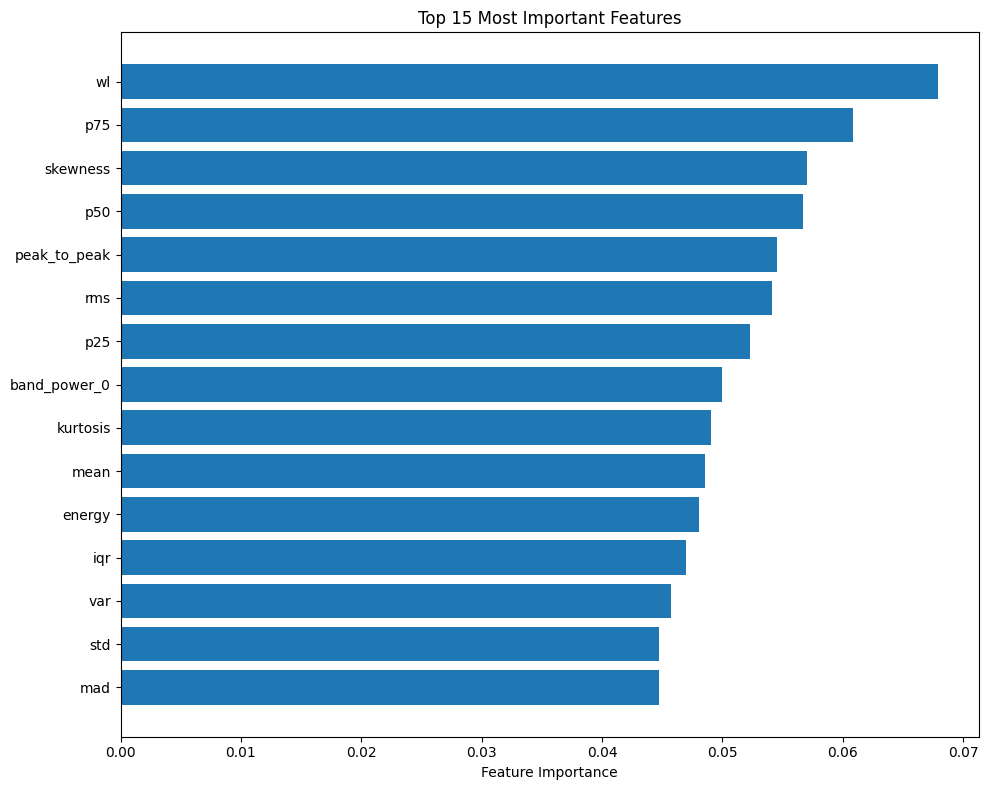

Top 10 features:
         feature  importance
8             wl    0.067907
14           p75    0.060839
10      skewness    0.057046
13           p50    0.056703
17  peak_to_peak    0.054512
3            rms    0.054116
12           p25    0.052284
21  band_power_0    0.050001
11      kurtosis    0.049019
0           mean    0.048577


In [8]:
# ## 4. Feature Selection and Visualization
# Visualize feature importance using Random Forest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y_binary)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 features:")
print(feature_importance.head(10))

# Select top features
top_features = feature_importance['feature'][:15].values
X_selected = X[top_features]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 11, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,585 (342.13 KB)

 Trainable params: 87,201 (340.63 KB)

 Non-trainable params: 384 (1.50 KB)


Training Random Forest...
Accuracy: 0.6622
Validation Accuracy (CV): 0.6578 (+/- 0.0042)
Cost Function: Gini impurity

Classification Report:
              precision    recall  f1-score   support

      Rotate       0.71      0.63      0.67      2099
       Pinch       0.62      0.70      0.66      1800

    accuracy                           0.66      3899
   macro avg       0.66      0.66      0.66      3899
weighted avg       0.67      0.66      0.66      3899


Training Gradient Boosting...
Accuracy: 0.6581
Validation Accuracy (CV): 0.6576 (+/- 0.0095)
Cost Function: Deviance

Classification Report:
              precision    recall  f1-score   support

      Rotate       0.70      0.65      0.67      2099
       Pinch       0.62      0.67      0.64      1800

    accuracy                           0.66      3899
   macro avg       0.66      0.66      0.66      3899
weighted avg       0.66      0.66      0.66      3899


Training SVM...
Accuracy: 0.6543
Validation Accuracy (CV): 0

390/390 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6234 - loss: 0.6453 - val_accuracy: 0.5365 - val_loss: 0.9055
Epoch 2/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6262 - loss: 0.6388 - val_accuracy: 0.5365 - val_loss: 1.0388
Epoch 3/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6327 - loss: 0.6351 - val_accuracy: 0.5365 - val_loss: 1.2792
Epoch 4/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6331 - loss: 0.6314 - val_accuracy: 0.5365 - val_loss: 1.4251
Epoch 5/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6355 - loss: 0.6330 - val_accuracy: 0.5365 - val_loss: 1.1635
Epoch 6/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6395 - loss: 0.6300 - val_accuracy: 0.5365 - val_loss: 1.3824
Epoch 7/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6359 - loss: 0.6313 - val_accuracy: 0.5365 - val_loss: 1.2427
Epoch 8/50
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6380 - loss: 0.6272 - val_accuracy: 0.536

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.5383
Validation Accuracy: 0.5365
Cost Function: binary_crossentropy


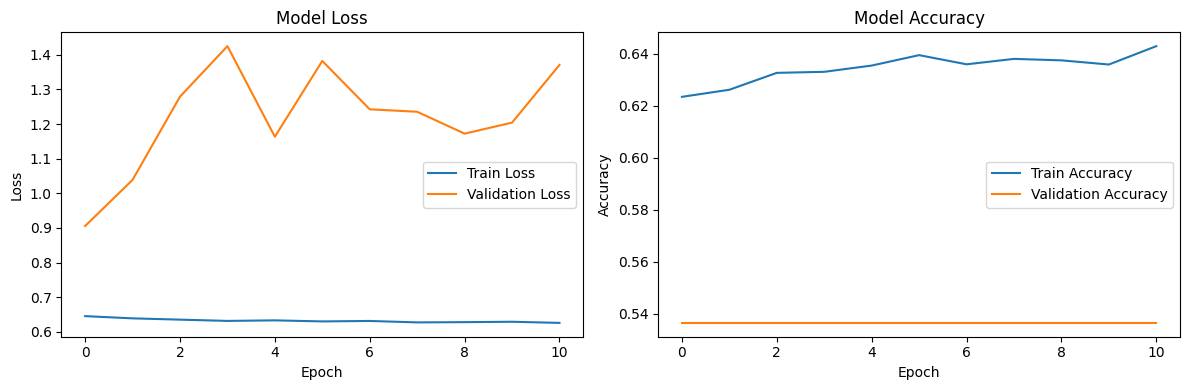


Classification Report:
              precision    recall  f1-score   support

      Rotate       0.54      1.00      0.70      2099
       Pinch       0.00      0.00      0.00      1800

    accuracy                           0.54      3899
   macro avg       0.27      0.50      0.35      3899
weighted avg       0.29      0.54      0.38      3899



In [9]:
# ## 5. Model Training and Evaluation
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store models and results
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Add CNN-LSTM if TensorFlow is available
if TF_AVAILABLE:
    # Prepare data for CNN-LSTM
    def create_cnn_lstm_data(data, labels, window_size=50, step_size=10):
        """Create windowed dataset for CNN-LSTM"""
        X = []
        y = []
        
        for i in range(0, len(data) - window_size, step_size):
            window = data[i:i + window_size]
            window_labels = labels[i:i + window_size]
            
            # Use majority voting for label
            label = np.bincount(window_labels).argmax()
            
            X.append(window)
            y.append(label)
        
        return np.array(X), np.array(y)
    
    # Create CNN-LSTM dataset
    X_cnn, y_cnn = create_cnn_lstm_data(
        df['filtered_value'].values,
        df['label'].values
    )
    
    # Convert labels to binary: 1 (rotate) -> 0, 2 (pinch) -> 1
    y_cnn_binary = (y_cnn == 2).astype(int)
    
    # Split data
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
        X_cnn, y_cnn_binary, test_size=0.2, random_state=42, stratify=y_cnn_binary
    )
    
    # Reshape for CNN-LSTM [samples, timesteps, features]
    X_train_cnn = X_train_cnn.reshape((X_train_cnn.shape[0], X_train_cnn.shape[1], 1))
    X_test_cnn = X_test_cnn.reshape((X_test_cnn.shape[0], X_test_cnn.shape[1], 1))
    
    # Define CNN-LSTM model
    def create_cnn_lstm_model(input_shape):
        model = Sequential()
        
        # CNN layers
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        
        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))
        
        # LSTM layers
        model.add(LSTM(64, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(32))
        model.add(Dropout(0.3))
        
        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    # Create model
    cnn_lstm_model = create_cnn_lstm_model((X_train_cnn.shape[1], 1))
    cnn_lstm_model.summary()
    
    # Add to models dictionary
    models['CNN-LSTM'] = cnn_lstm_model

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train CNN-LSTM separately
    if name == 'CNN-LSTM':
        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(
            'cnn_lstm_best_model.h5', 
            monitor='val_accuracy', 
            save_best_only=True, 
            mode='max'
        )
        
        # Train model
        history = model.fit(
            X_train_cnn, y_train_cnn,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, model_checkpoint],
            verbose=1
        )
        
        # Load best model
        model = load_model('cnn_lstm_best_model.h5')
        
        # Evaluate on test set
        test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
        y_pred = (model.predict(X_test_cnn) > 0.5).astype(int).flatten()
        y_prob = model.predict(X_test_cnn).flatten()
        
        # Get validation accuracy from training history
        val_accuracy = max(history.history['val_accuracy'])
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': test_accuracy,
            'val_accuracy': val_accuracy,
            'cost_function': 'binary_crossentropy',
            'predictions': y_pred,
            'probabilities': y_prob,
            'history': history
        }
        
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Cost Function: binary_crossentropy")
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    else:  # Traditional ML models
        # Use scaled data for SVM, NN, and KNN
        if name in ['SVM', 'Neural Network', 'KNN']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
            
            # Cross-validation
            cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        # Determine cost function
        if name == 'Random Forest':
            cost_function = 'Gini impurity'
        elif name == 'Gradient Boosting':
            cost_function = 'Deviance'
        elif name == 'SVM':
            cost_function = 'Hinge loss'
        elif name == 'Neural Network':
            cost_function = 'Log loss'
        elif name == 'KNN':
            cost_function = 'N/A (instance-based)'
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'val_accuracy': cv_scores.mean(),
            'cost_function': cost_function,
            'cv_scores': cv_scores,
            'predictions': y_pred,
            'probabilities': y_prob
        }
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Validation Accuracy (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        print(f"Cost Function: {cost_function}")
    
    print("\nClassification Report:")
    print(classification_report(y_test if name != 'CNN-LSTM' else y_test_cnn, 
                              y_pred, 
                              target_names=['Rotate', 'Pinch']))




Model Comparison:
               Model  Test Accuracy  Validation Accuracy    CV Std  \
3     Neural Network       0.664529             0.655553  0.011123   
0      Random Forest       0.662221             0.657797  0.004199   
1  Gradient Boosting       0.658117             0.657605  0.009461   
2                SVM       0.654270             0.653181  0.010444   
4                KNN       0.634265             0.613555  0.009913   
5           CNN-LSTM       0.538343             0.536538  0.000000   

          Cost Function  
3              Log loss  
0         Gini impurity  
1              Deviance  
2            Hinge loss  
4  N/A (instance-based)  
5   binary_crossentropy  


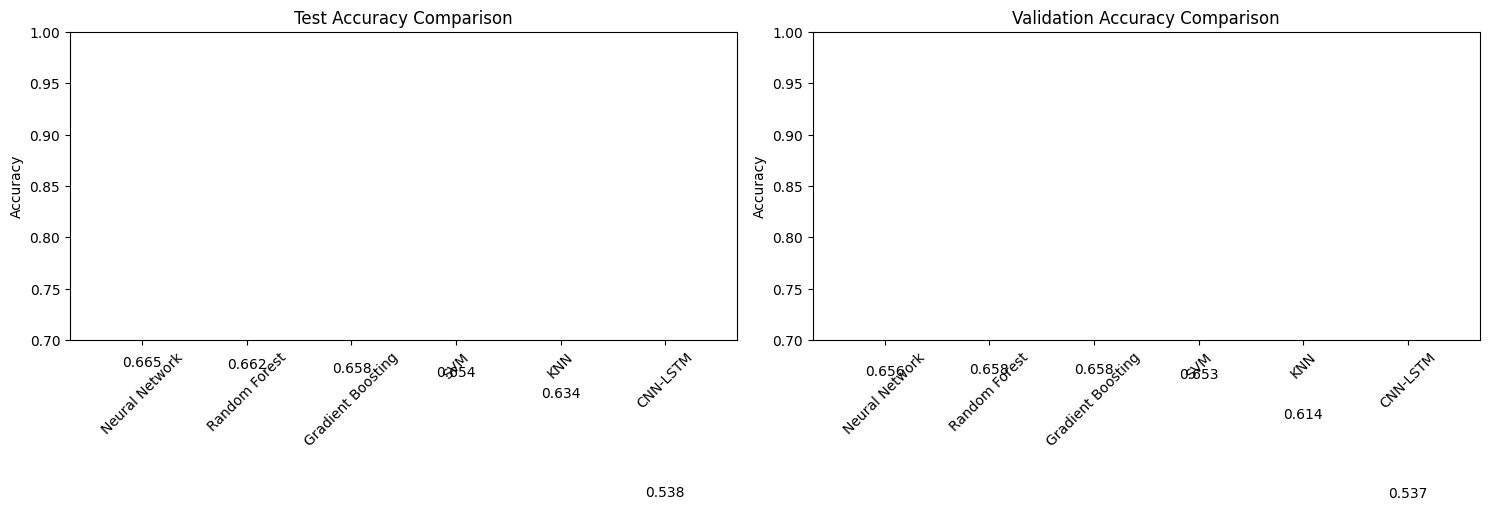


Best model: Neural Network with Test Accuracy: 0.6645


In [10]:
# ## 6. Model Comparison and Selection
# Compare models
model_names = list(results.keys())
test_accuracies = [results[name]['accuracy'] for name in model_names]
val_accuracies = [results[name]['val_accuracy'] for name in model_names]

# For traditional models, get CV std
cv_stds = []
for name in model_names:
    if name == 'CNN-LSTM':
        cv_stds.append(0)  # No std for CNN-LSTM
    else:
        cv_stds.append(results[name]['cv_scores'].std())

comparison_df = pd.DataFrame({
    'Model': model_names,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies,
    'CV Std': cv_stds,
    'Cost Function': [results[name]['cost_function'] for name in model_names]
}).sort_values('Test Accuracy', ascending=False)

print("\nModel Comparison:")
print(comparison_df)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Test Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], color='skyblue')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylim([0.7, 1.0])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center')

# Validation Accuracy comparison with error bars
axes[1].bar(comparison_df['Model'], comparison_df['Validation Accuracy'], color='lightgreen')
axes[1].errorbar(range(len(comparison_df)), comparison_df['Validation Accuracy'], 
                 yerr=comparison_df['CV Std'], fmt='none', color='black', capsize=5)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy Comparison')
axes[1].set_ylim([0.7, 1.0])
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(comparison_df['Model'], rotation=45)
for i, v in enumerate(comparison_df['Validation Accuracy']):
    axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

# Select best model based on test accuracy
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name} with Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")


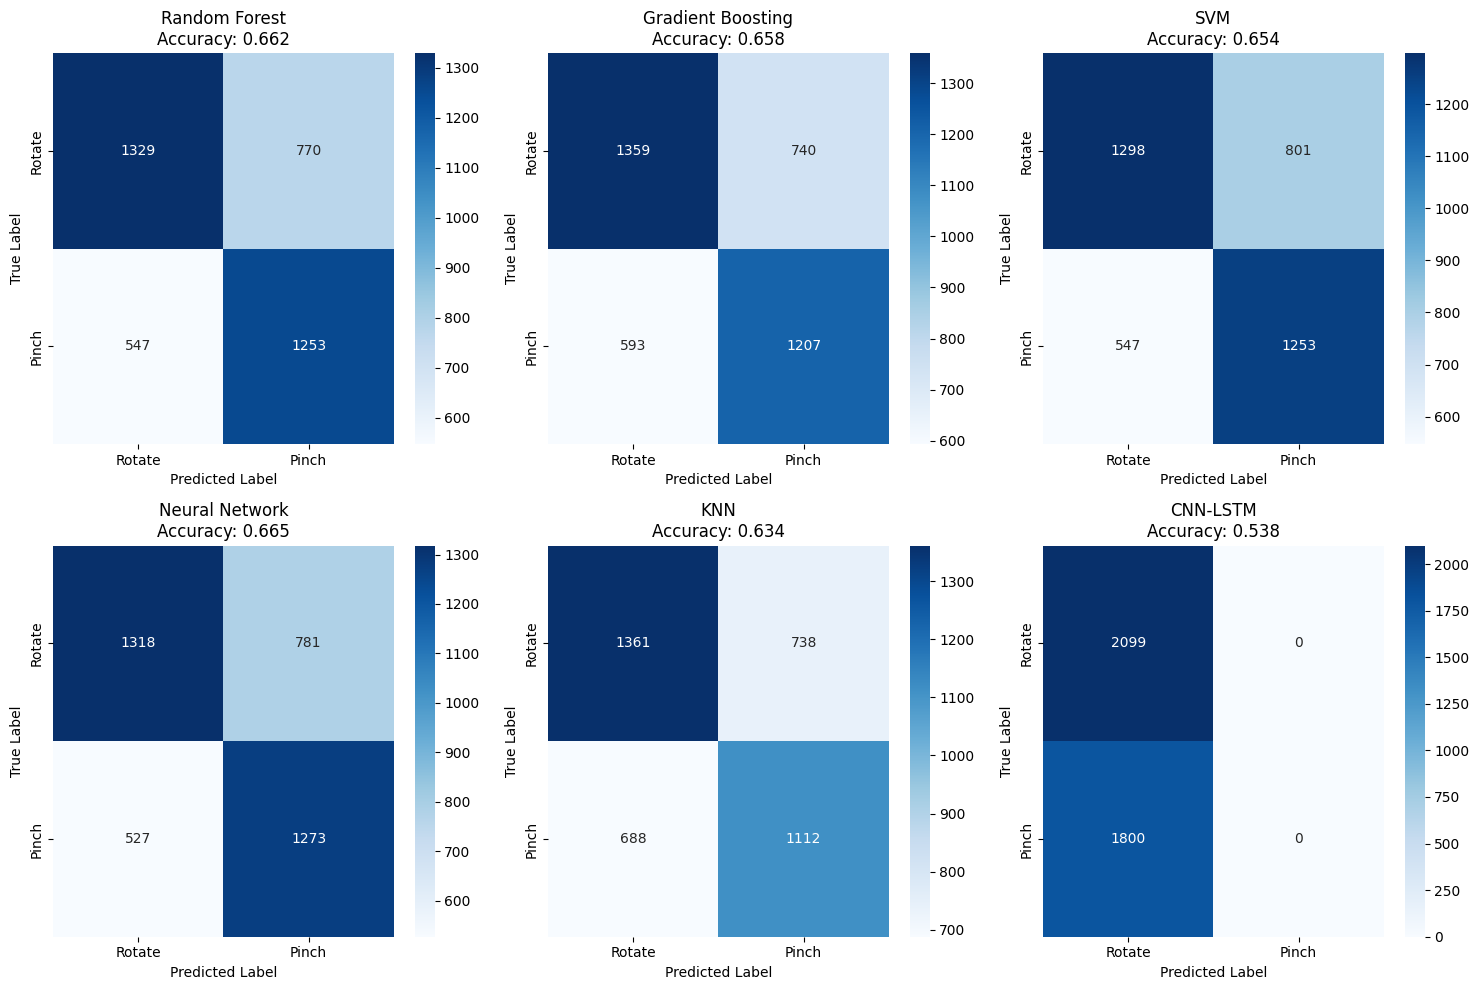

In [11]:
# ## 7. Confusion Matrix and Detailed Evaluation
# Plot confusion matrices for all models
num_models = len(results)
rows = (num_models + 2) // 3  # Calculate rows needed (3 models per row)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.ravel()  # Flatten axes array

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test if name != 'CNN-LSTM' else y_test_cnn, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Rotate', 'Pinch'], yticklabels=['Rotate', 'Pinch'])
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

# Hide any unused subplots
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# ## 8. Save Best Model for Deployment
# Save the best model and preprocessing parameters
if best_model_name == 'CNN-LSTM':
    # Save Keras model
    best_model.save('models2/best_cnn_lstm_model.h5')
    model_data = {
        'model_type': best_model_name,
        'model_path': 'best_cnn_lstm_model.h5',
        'window_size': extractor.window_size,
        'step_size': extractor.step_size
    }
else:
    # Save scikit-learn model
    model_data = {
        'model': best_model,
        'scaler': scaler if best_model_name in ['SVM', 'Neural Network', 'KNN'] else None,
        'feature_names': top_features,
        'window_size': extractor.window_size,
        'step_size': extractor.step_size,
        'model_type': best_model_name
    }
    joblib.dump(model_data, 'models2/emg_gesture_model.pkl')

print(f"Model saved for {best_model_name}")

# Also save as separate components for flexibility
if best_model_name != 'CNN-LSTM':
    joblib.dump(best_model, 'models2/best_model.pkl')
    joblib.dump(scaler, 'models2/scaler.pkl')
    np.save('feature_names.npy', top_features)
    print("Individual components saved:")
    print("- best_model.pkl")
    print("- scaler.pkl")
    print("- feature_names.npy")



Model saved for Neural Network
Individual components saved:
- best_model.pkl
- scaler.pkl
- feature_names.npy


In [15]:
# ## 9. Real-time Prediction Function
def predict_gesture_realtime(emg_buffer, model_data):
    """
    Make real-time prediction from EMG buffer
    
    Args:
        emg_buffer: numpy array of EMG values (length = window_size)
        model_data: dictionary containing model and preprocessing parameters
    
    Returns:
        gesture: 'pinch' or 'rotate'
        confidence: probability of the predicted gesture
    """
    if model_data['model_type'] == 'CNN-LSTM':
        # Load Keras model
        model = load_model(model_data['model_path'])
        
        # Reshape for CNN-LSTM
        emg_buffer = emg_buffer.reshape((1, emg_buffer.shape[0], 1))
        
        # Make prediction
        prediction_prob = model.predict(emg_buffer)[0][0]
        prediction = 1 if prediction_prob > 0.5 else 0
        confidence = prediction_prob if prediction == 1 else 1 - prediction_prob
        
    else:
        # Extract features
        extractor = FeatureExtractor(window_size=len(emg_buffer), step_size=1)
        features = extractor.extract_time_domain_features(emg_buffer)
        freq_features = extractor.extract_frequency_domain_features(emg_buffer)
        features.update(freq_features)
        
        # Create feature dataframe
        feature_df = pd.DataFrame([features])
        
        # Select relevant features
        feature_df = feature_df[model_data['feature_names']]
        
        # Scale if necessary
        if model_data['scaler'] is not None:
            feature_values = model_data['scaler'].transform(feature_df)
        else:
            feature_values = feature_df.values
        
        # Make prediction
        model = model_data['model']
        prediction = model.predict(feature_values)[0]
        probability = model.predict_proba(feature_values)[0]
        
        confidence = probability[prediction]
    
    gesture = 'pinch' if prediction == 1 else 'rotate'
    return gesture, confidence

# Test the real-time prediction function
test_buffer = df['filtered_value'].values[:50]  # Get a test window
if best_model_name == 'CNN-LSTM':
    loaded_model_data = {
        'model_type': 'CNN-LSTM',
        'model_path': 'best_cnn_lstm_model.h5',
        'window_size': extractor.window_size,
        'step_size': extractor.step_size
    }
else:
    loaded_model_data = joblib.load('models2/emg_gesture_model.pkl')

gesture, confidence = predict_gesture_realtime(test_buffer, loaded_model_data)
print(f"\nTest prediction: {gesture} (confidence: {confidence:.2%})")


Test prediction: rotate (confidence: 94.60%)


In [16]:
# ## 10. ESP32 Integration Code
esp32_code = """
// ESP32-S3 EMG Gesture Recognition
// Using Gravity Analog EMG Sensor by OYMotion
#include <Arduino.h>
const int EMG_PIN = 34;  // Analog input pin
const int WINDOW_SIZE = 50;
const int STEP_SIZE = 10;
const int SAMPLING_RATE = 1000;  // Hz
float emg_buffer[WINDOW_SIZE];
int buffer_index = 0;
// Feature extraction functions
float calculate_mean(float* data, int len) {
    float sum = 0;
    for(int i = 0; i < len; i++) {
        sum += data[i];
    }
    return sum / len;
}
float calculate_std(float* data, int len) {
    float mean = calculate_mean(data, len);
    float sum = 0;
    for(int i = 0; i < len; i++) {
        sum += pow(data[i] - mean, 2);
    }
    return sqrt(sum / len);
}
float calculate_rms(float* data, int len) {
    float sum = 0;
    for(int i = 0; i < len; i++) {
        sum += pow(data[i], 2);
    }
    return sqrt(sum / len);
}
int calculate_zcr(float* data, int len) {
    int count = 0;
    for(int i = 1; i < len; i++) {
        if((data[i] >= 0 && data[i-1] < 0) || 
           (data[i] < 0 && data[i-1] >= 0)) {
            count++;
        }
    }
    return count;
}
void setup() {
    Serial.begin(115200);
    pinMode(EMG_PIN, INPUT);
}
void loop() {
    // Read EMG value
    int raw_value = analogRead(EMG_PIN);
    float emg_value = (raw_value / 4095.0) * 4000;  // Convert to 0-4000 range
    
    // Add to buffer
    emg_buffer[buffer_index] = emg_value;
    buffer_index = (buffer_index + 1) % WINDOW_SIZE;
    
    // Process when buffer is full
    if(buffer_index == 0) {
        // Extract features
        float mean = calculate_mean(emg_buffer, WINDOW_SIZE);
        float std = calculate_std(emg_buffer, WINDOW_SIZE);
        float rms = calculate_rms(emg_buffer, WINDOW_SIZE);
        int zcr = calculate_zcr(emg_buffer, WINDOW_SIZE);
        
        // Send features to serial for processing
        Serial.print("FEATURES:");
        Serial.print(mean); Serial.print(",");
        Serial.print(std); Serial.print(",");
        Serial.print(rms); Serial.print(",");
        Serial.print(zcr);
        Serial.println();
    }
    
    delay(1000 / SAMPLING_RATE);  // Maintain sampling rate
}
"""

print("\n" + "="*50)
print("ESP32 Integration Code saved in the script")
print("="*50)

# Save ESP32 code to file
with open('esp32_emg_gesture.ino', 'w') as f:
    f.write(esp32_code)
print("ESP32 code saved as 'esp32_emg_gesture.ino'")
print("\n✅ Complete EMG Gesture Recognition System Ready!")
print("\nNext steps:")
print("1. Upload the ESP32 code to your microcontroller")
print("2. Use the saved model for real-time predictions")
print("3. Fine-tune the model with more data if needed")


ESP32 Integration Code saved in the script
ESP32 code saved as 'esp32_emg_gesture.ino'

✅ Complete EMG Gesture Recognition System Ready!

Next steps:
1. Upload the ESP32 code to your microcontroller
2. Use the saved model for real-time predictions
3. Fine-tune the model with more data if needed
